In [28]:
import tweepy
from pprint import pprint
import psycopg2
import time

import numpy as np
import pandas as pd

from nltk.stem import WordNetLemmatizer
import nltk
import re

from wordcloud import WordCloud
from textblob import TextBlob

# Authentication and Fresh Posts from Personal Twitter Home Timeline

In [2]:
# Twitter API authentication

api_key = <API key>
api_secret_key = <API secret>
access_token = <Access token>
access_token_secret = <Access secret>

# authorize the API Key
authentication = tweepy.OAuthHandler(api_key, api_secret_key)

# authorization to user's access token and access token secret
authentication.set_access_token(access_token, access_token_secret)

# call the api
api = tweepy.API(authentication)

public_tweet = api.home_timeline(count=5)

for tweet in public_tweet:
    print("-->",tweet.text)

--> Well, it’s snowing here in Cincinnati.  Not a lot, but still snowing.  😢
--> RT @_CJMayes: This months What’s Good is with @ZaksViz , covering how to improve business dashboards!
Zak has recently been publishing a nu…
--> Check out the Top 10 Elevate Sessions as voted on by attendees – Watch the replays, from choosing yr next career op… https://t.co/ufPlpOurHk
--> https://t.co/Q52Jojssxs
--> RT @ProfFeynman: You are under no obligation to remain the same person you were a year ago, a month ago, or even a day ago. You are here to…


# Tweets from Specific Twitter User

In [3]:
# Streaming tweets from user timeline

user = "rn_critcare"
public_tweet = api.user_timeline(id=user,count=5)

for tweet in public_tweet:
    print("-->",tweet.text)

--> Me at work: Takes care of the sickest patients in our region. Respond to code blues. Train new staff. Eat healthy,… https://t.co/7jvkeAaXTW
--> @yitsyeti It's been a hashtag in my profile for a while now!
--> @DrJRubenstein Yes! Warms my heart when we address patient values and quality of life. Especially before the tube goes in.
--> @andellis I would think this wouldn't need to be said be yes. Definitely have a meaningful discuss that is clear and understood.
--> One of our consultants told our fellow "I never put in any tube I'm not confident I can take out" and this is somet… https://t.co/OAlFtUxDrR


# Tweets based on Key Words

### showing search result in JSON (key values)

In [4]:
# Retrieve tweets
result = api.search(['vaccine', 'vax', 'Pfizer', 'Moderna', 'Johnson & Johnson'], lang='en', count=10)

pprint(result[0]._json.keys())
# pprint(result[0].user._json)
# pprint(result[4].entities['hashtags'])

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'metadata', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang'])


# Creating Tables in PostgreSQL Database

### using pgAdmin 4

In [7]:
# Table creation
commands = (# Table 1
            '''Create Table TwitterUser(User_Id BIGINT PRIMARY KEY, User_Name TEXT);''',
            # Table 2
            '''Create Table TwitterTweet(Tweet_Id BIGINT PRIMARY KEY,
                                         User_Id BIGINT,
                                         Tweet TEXT,
                                         Retweet_Count INT,
                                         CONSTRAINT fk_user
                                             FOREIGN KEY(User_Id)
                                                 REFERENCES TwitterUser(User_Id));''',
            # Table 3
            '''Create Table TwitterEntity(Id SERIAL PRIMARY KEY,
                                         Tweet_Id BIGINT,
                                         Hashtag TEXT,
                                         CONSTRAINT fk_user
                                             FOREIGN KEY(Tweet_Id)
                                                 REFERENCES TwitterTweet(Tweet_Id));''')

### Don’t forget to commit the changes and close connection after use so that the database doesn’t get locked!

# Connect to the Database (DB)

Whenever a tweet needs to be saved to twitterdb:

1. open connection to twitterdb
1. execute SQL command to db
1. commit changes
1. close the connection

Done in code below:

In [9]:
# Insert Tweet data into database
def dbConnect(user_id, user_name, tweet_id, tweet, retweet_count, hashtags):
    
    # Connection to database server
    conn = psycopg2.connect(host="localhost",database=<postgres db>,port=5432,user=<postgres user name>,password=<postgres user pw>)

    cur = conn.cursor()

    # insert user information
    command = '''INSERT INTO TwitterUser (user_id, user_name) VALUES (%s,%s) ON CONFLICT
                 (User_Id) DO NOTHING;'''
    cur.execute(command,(user_id,user_name))

    # insert tweet information
    command = '''INSERT INTO TwitterTweet (tweet_id, user_id, tweet, retweet_count) VALUES (%s,%s,%s,%s);'''
    cur.execute(command,(tweet_id, user_id, tweet, retweet_count))
    
    # insert entity information
    for i in range(len(hashtags)):
        hashtag = hashtags[i]
        command = '''INSERT INTO TwitterEntity (tweet_id, hashtag) VALUES (%s,%s);'''
        cur.execute(command,(tweet_id, hashtag))
    
    # Commit changes
    conn.commit()
    
    # Disconnect
    cur.close()
    conn.close()

# Streaming Tweets into DB 🤙

In [5]:
class MyStreamListener(tweepy.StreamListener):
    
    def __init__(self, time_limit=300):
        self.start_time = time.time()
        self.limit = time_limit
        super(MyStreamListener, self).__init__()
    
    def on_connect(self):
        print("Connected to Twitter API.")
        
    def on_status(self, status):
        
        
        # Tweet ID
        tweet_id = status.id
        
        # User ID
        user_id = status.user.id
        
        # Username
        username = status.user.name
        
        
        # Tweet
        if status.truncated == True:
            tweet = status.extended_tweet['full_text']
            hashtags = status.extended_tweet['entities']['hashtags']
        else:
            tweet = status.text
            hashtags = status.entities['hashtags']
        
        # Read hastags
        hashtags = read_hashtags(hashtags)            
        
        # Retweet count
        retweet_count = status.retweet_count
        
        # Language
        lang = status.lang
        
        
        # If tweet is not a retweet and tweet is in English
        if not hasattr(status, "retweeted_status") and lang=="en":
            # Connect to database
            dbConnect(user_id, username, tweet_id, tweet, retweet_count, hashtags)
            
        if (time.time() - self.start_time) > self.limit:
            
            print(time.time(), self.start_time, self.limit)
            return False
            
    def on_error(self, status_code):
        if status_code == 420:
            # Returning False in on_data disconnects the stream
            return False

In [6]:
# Extract hashtags
def read_hashtags(tag_list):
    hashtags = []
    for tag in tag_list:
        hashtags.append(tag['text'])
    return hashtags

In [10]:
# Streaming tweets

myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth=api.auth, listener=myStreamListener,
                        tweet_mode="extended")
myStream.filter(track=['vaccine', 'vax', 'Pfizer', 'Moderna', 'Johnson & Johnson'])

Connected to Twitter API.
1617295982.277985 1617295682.093235 300


# Pulling Tweets from Postgres DB

In [11]:
# Cleaning the tweets
def preprocess(tweet):
    
    # remove links
    tweet = re.sub(r'http\S+', '', tweet)
    # remove mentions
    tweet = re.sub("@\w+","",tweet)
    # alphanumeric and hashtags
    tweet = re.sub("[^a-zA-Z#]"," ",tweet)
    # remove multiple spaces
    tweet = re.sub("\s+"," ",tweet)
    tweet = tweet.lower()
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    sent = ' '.join([lemmatizer.lemmatize(w) for w in tweet.split() if len(lemmatizer.lemmatize(w))>3])

    return sent

In [12]:
# Connecting to the Database
def DbConnect(query):
    
    conn = psycopg2.connect(host="localhost",database=<postgres db>,port=5432,user=<postgres user name>,password=<postgres user pw>)
    curr = conn.cursor()
    
    curr.execute(query)
    
    rows = curr.fetchall()
    
    return rows

# Create dataframe from streamed tweets

In [17]:
data_tweet = DbConnect("SELECT User_Id, Tweet_Id, Tweet FROM TwitterTweet;")

df_tweet = pd.DataFrame(columns=['User_Id','Tweet_Id','Clean_Tweet'])

for data in data_tweet:
    index = len(df_tweet)
    df_tweet.loc[index,'User_Id'] = data[0]
    df_tweet.loc[index,'Tweet_Id'] = data[1]
    df_tweet.loc[index,'Clean_Tweet'] = preprocess(data[2])
    
df_tweet.head()

,User_Id,Tweet_Id,Clean_Tweet
0,1016913954784722944,1377489297905868800,#largestvaccinedrive vaccine vaccinated stay s...
1,1066648057,1377489298816073733,that fucking person ruin everyone want vaccine...
2,2701219328,1377489300141445131,hearing from multiple place that people aren a...
3,1287527365988540418,1377489300615528451,will never forget these trumpies that scared v...
4,1093836341606002688,1377489300577603584,covid more indian could begin manufacturing sp...


# Tweets Analysis

## Most common words

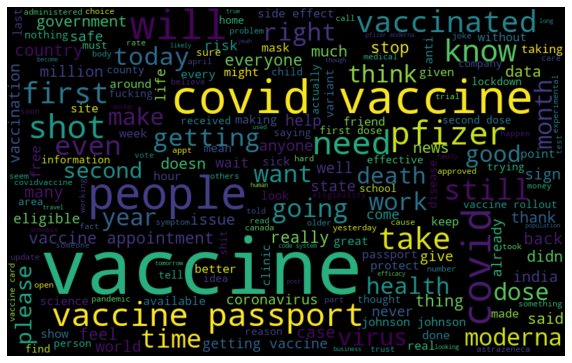

In [25]:
# Most commomly occuring words
def keywords():
    all_words = ' '.join([text for text in df_tweet['Clean_Tweet']])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

keywords()

Very nice. What came up as most popular words were not just those put in the stream filter. :)

# Sentiment Labeling 😃

In [29]:
def sentiment(tweet):

    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    
df_tweet['Sentiment'] = df_tweet['Clean_Tweet'].apply(sentiment)

df_tweet.head(20)

,User_Id,Tweet_Id,Clean_Tweet,Sentiment
0,1016913954784722944,1377489297905868800,#largestvaccinedrive vaccine vaccinated stay s...,1
1,1066648057,1377489298816073733,that fucking person ruin everyone want vaccine...,-1
2,2701219328,1377489300141445131,hearing from multiple place that people aren a...,1
3,1287527365988540418,1377489300615528451,will never forget these trumpies that scared v...,0
4,1093836341606002688,1377489300577603584,covid more indian could begin manufacturing sp...,1
5,796251801502683137,1377489309486354432,vaccine passport internal passport full stop j...,1
6,433849505,1377489311726100482,follow tweet below look #covid case vaccine ov...,1
7,1018274364863598592,1377489312460070914,federal government might have completed vaccin...,0
8,327603996,1377489312984539136,just found disney aren eligible vaccine health...,-1
9,2963425867,1377489314595016709,passport ready some totalitarianism here,1


## Check out whole Clean_Tweet column to do some manual label verification.

In [35]:
pd.set_option("display.max_colwidth", None)
df_tweet.head(15)

,User_Id,Tweet_Id,Clean_Tweet,Sentiment
0,1016913954784722944,1377489297905868800,#largestvaccinedrive vaccine vaccinated stay safe #indiafightscovid #unite fightcorona,1
1,1066648057,1377489298816073733,that fucking person ruin everyone want vaccine fine your choice then deal with consequence that decision inconsiderate prick like yourself going ruin this again others,-1
2,2701219328,1377489300141445131,hearing from multiple place that people aren able vaccine dose,1
3,1287527365988540418,1377489300615528451,will never forget these trumpies that scared vaccine were same telling everyone take untested hydroxychloroquine last year,0
4,1093836341606002688,1377489300577603584,covid more indian could begin manufacturing sputnik vaccine download economic time stay updated with business news,1
5,796251801502683137,1377489309486354432,vaccine passport internal passport full stop just because word vaccine beginning doesn change what,1
6,433849505,1377489311726100482,follow tweet below look #covid case vaccine over time healthcare worker month after dose case declined great sign data limitation vaccination status case available thanks vaccine data,1
7,1018274364863598592,1377489312460070914,federal government might have completed vaccine rollout then,0
8,327603996,1377489312984539136,just found disney aren eligible vaccine healthcare shit that suck,-1
9,2963425867,1377489314595016709,passport ready some totalitarianism here,1


One was ambiguous so total sampled: 14. Out of this, 3 were incorrect. So 11/14 is approximately 79% accurate.

# Viz of overall sentiment on 'vaccine', 'vax', 'Pfizer', 'Moderna', 'Johnson & Johnson'-related tweets.

<AxesSubplot:>

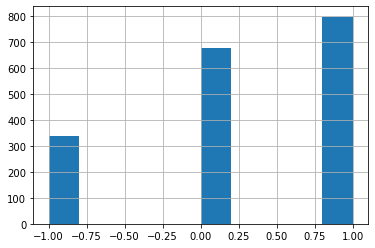

In [48]:
df_tweet.Sentiment.hist()

There is mostly positive sentiment about the vaccines. Negative sentiment is less than half of positive counts. That is hopeful.